<a href="https://colab.research.google.com/github/hewness/EN.625.603.86.FA24/blob/main/EN_625_603_86_FA24_Module_13_Data_Analysis_Project_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Project

This project seeks to analyze a data set of injuries suffered by upper elementary to high school children and create a model to predict the injury duration. Such a prediction is important for caregivers and providers in terms of planning the necessary care for the child.


In [70]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import matplotlib.pylab as plt
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from google.colab import drive, data_table
from statsmodels.api import qqplot
from statsmodels.tools.eval_measures import mse
from sklearn.preprocessing import MinMaxScaler

data_table.enable_dataframe_formatter()

In [71]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [72]:
BASE_DATA_DIR = '/content/gdrive/MyDrive/EN.625.603.86.FA24/module_13/data'
INJURY_DATA_FILENAME = 'Injury_Data.csv'

injury_data_file_path = os.path.join(BASE_DATA_DIR, INJURY_DATA_FILENAME)

In [73]:
injury_data_df = pd.read_csv(injury_data_file_path)
injury_data_df['injury_type'] = injury_data_df['injury_type'].fillna('other')

## Exploratory Data Analysis

In [74]:
# Look at how the first 25 rows look like
data_table.DataTable(injury_data_df.head(25))

,Age,sex,race,injury_type,Dazed,Care Site,Hospital_Admit,Xray,Intensity_Score,Injury_Duration,Rating1,Rating2,Rating3,Rating4,Rating5,Rating6,Rating7_Qual,Rating8,Rating9
0,16,male,white,sport,Yes,Emergency,No,Yes,NaN,6.00,99.0,98.0,8.0,NaN,NaN,101.0,NaN,NaN,NaN
1,14,male,black,fall,No,Emergency,No,Yes,9.0,1.00,70.0,96.0,7.0,NaN,2.0,NaN,abnormal,NaN,NaN
2,15,female,other,fall,No,Emergency,No,Yes,NaN,6.00,NaN,100.0,9.0,NaN,9.0,NaN,normal,NaN,NaN
3,17,male,white,fall,No,Emergency,Yes,Yes,NaN,2.00,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,male,white,assault,No,PrimaryCare,No,Yes,NaN,20.00,90.0,80.0,NaN,NaN,NaN,NaN,normal,NaN,NaN
5,18,male,other,fall,No,Emergency,No,Yes,NaN,8.00,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN,NaN
6,15,male,white,fall,No,Emergency,No,No,NaN,12.00,100.0,90.0,9.0,NaN,10.0,NaN,abnormal,NaN,NaN
7,16,female,white,fall,No,Emergency,No,Yes,9.0,4.00,10.0,90.0,8.0,NaN,8.0,NaN,normal,NaN,NaN
8,16,female,black,vehicle,No,Emergency,No,Yes,NaN,19.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12,male,white,assault,No,Emergency,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,normal,NaN,NaN


In [75]:
# Extract and Clean Data universe
# Remove any row with a column with NA data
categories = ['injury_type', 'Dazed', 'Hospital_Admit', 'Xray']
values = ['Intensity_Score', 'Injury_Duration', 'Age']
columns = categories + values
injury_data_df = injury_data_df[columns].dropna()

In [76]:
# Retrieve key basic statistics on the dataset
data_table.DataTable(injury_data_df.describe())

,Intensity_Score,Injury_Duration,Age
count,85.000000,85.000000,85.000000
mean,8.670588,7.174471,15.082353
std,12.541729,9.301923,2.059888
min,0.000000,0.290000,8.000000
25%,0.000000,2.000000,14.000000
50%,2.000000,4.000000,15.000000
75%,12.000000,8.000000,17.000000
max,60.000000,52.000000,18.000000


## Frequency of Categorical Variables

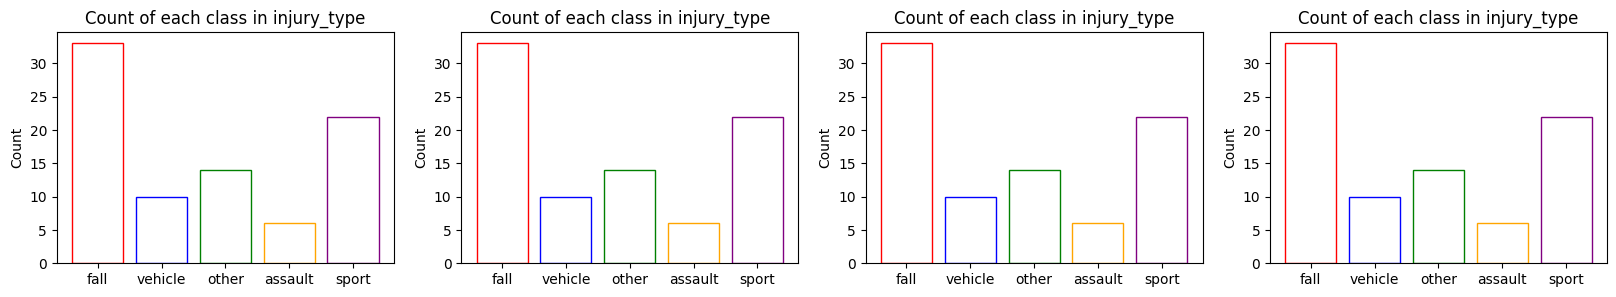

In [77]:
import math

f, ax = plt.subplots(1, 4, figsize = (20, 3))

colors = ['red', 'blue', 'green', 'orange', 'purple']

column_idx = 0
category_idx = 0

for column_idx, category in enumerate(categories):

    category = categories[category_idx]

    data = injury_data_df[categories]

    classes = list(data[category].unique())

    for class_idx, class_name in enumerate(classes):
        ax[column_idx].bar(class_name, data[data[category]==class_name].shape[0], fill=False, label=class_name, edgecolor=colors[class_idx])

    ax[column_idx].set_ylabel('Count')
    ax[column_idx].set_title('Count of each class in {}'.format(category))

## Distribution of Categorical Variables

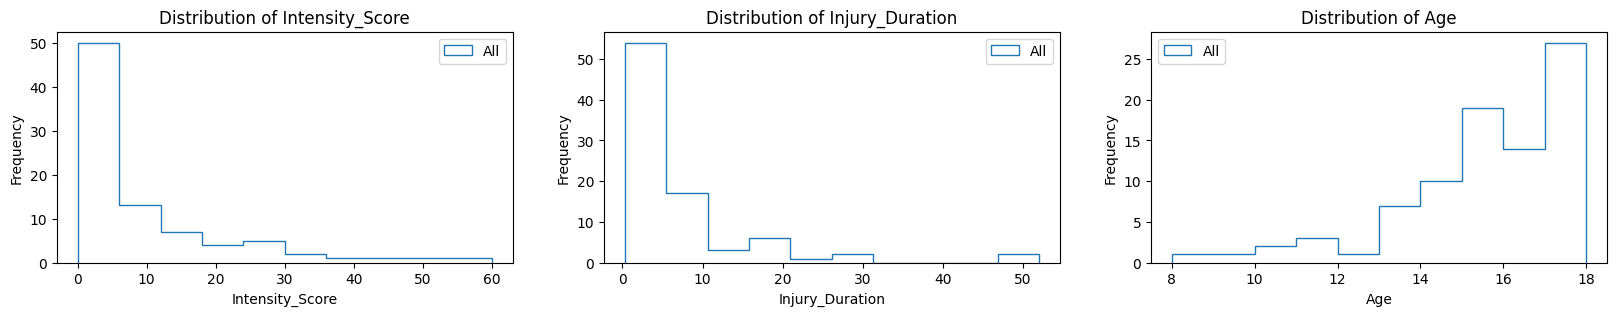

In [78]:
values = ['Intensity_Score', 'Injury_Duration', 'Age']

f, ax = plt.subplots(1, len(values), figsize = (20, 3))

for column_idx, value in enumerate(values):

    data = injury_data_df[value]
    ax[column_idx].hist(data, fill=False, histtype='step', label='All')
    ax[column_idx].set_xlabel(value)
    ax[column_idx].set_ylabel('Frequency');
    ax[column_idx].set_title('Distribution of {}'.format(value));

    ax[column_idx].legend()

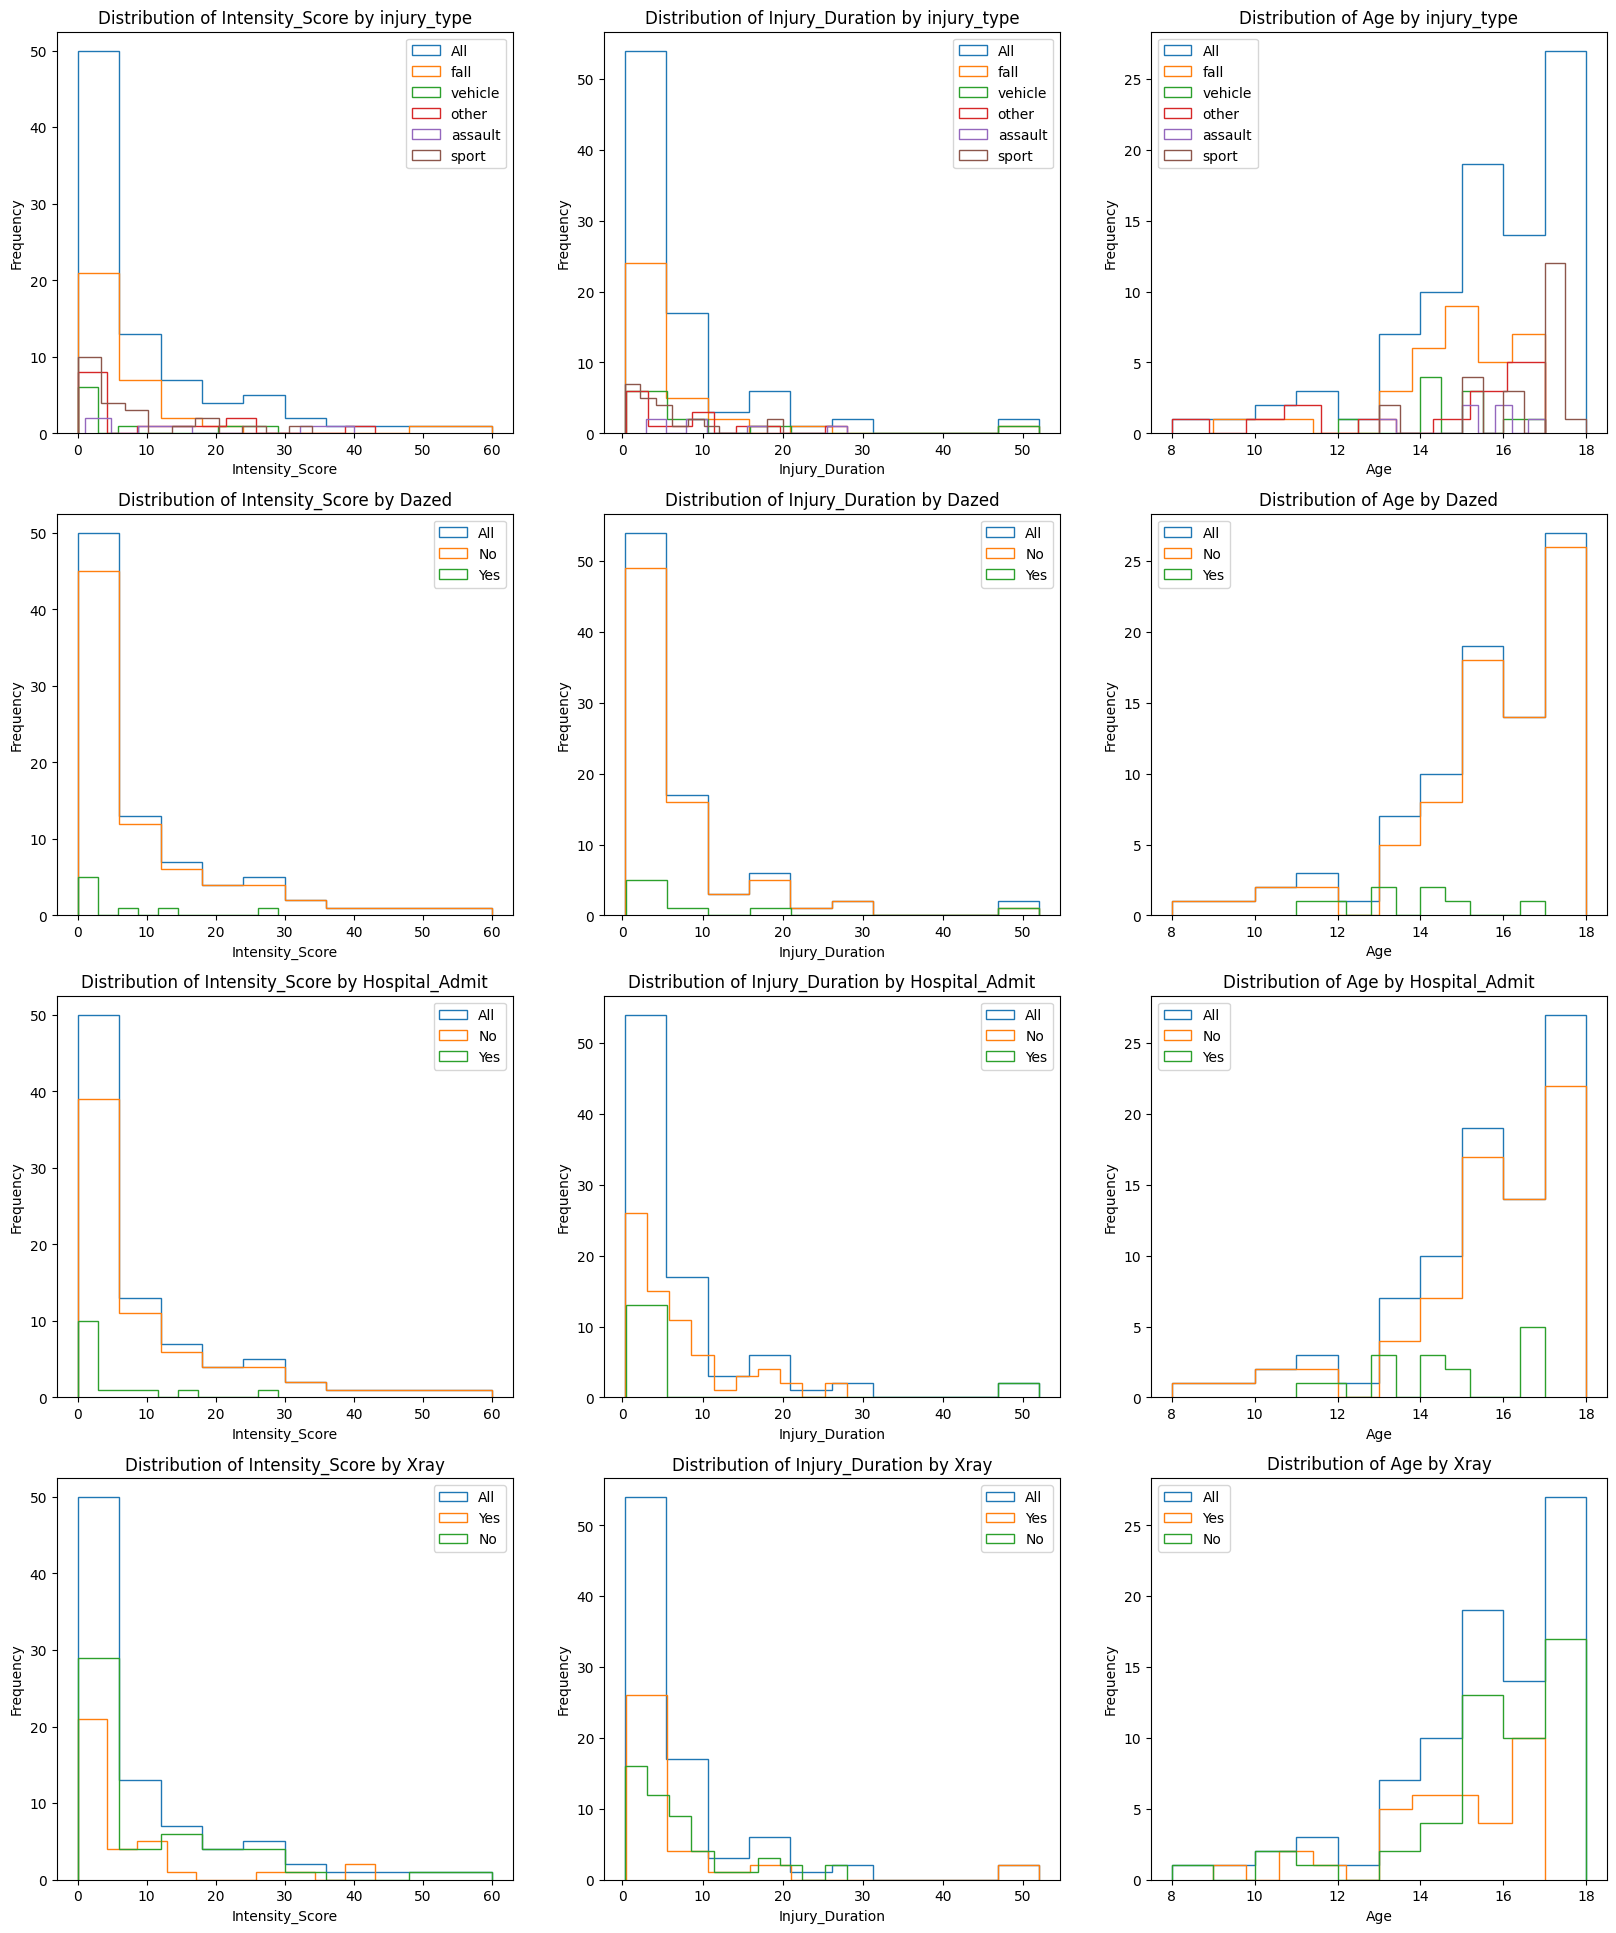

In [79]:

values = ['Intensity_Score', 'Injury_Duration', 'Age']

f, ax = plt.subplots(len(categories), len(values), figsize = (20, len(categories)*6))

for category_idx, category in enumerate(categories):

    for column_idx, value in enumerate(values):

        data = injury_data_df[value]
        ax[category_idx, column_idx].hist(data, fill=False, histtype='step', label='All')
        ax[category_idx, column_idx].set_xlabel(value)
        ax[category_idx, column_idx].set_ylabel('Frequency');
        ax[category_idx, column_idx].set_title('Distribution of {} by {}'.format(value, category));

        classes = list(injury_data_df[category].unique())

        for class_idx, class_name in enumerate(classes):
            ax[category_idx, column_idx].hist(injury_data_df[injury_data_df[category] == class_name][value], fill=False, histtype='step', label=class_name)

        ax[category_idx, column_idx].legend()

# Scatter Plots of Vector values

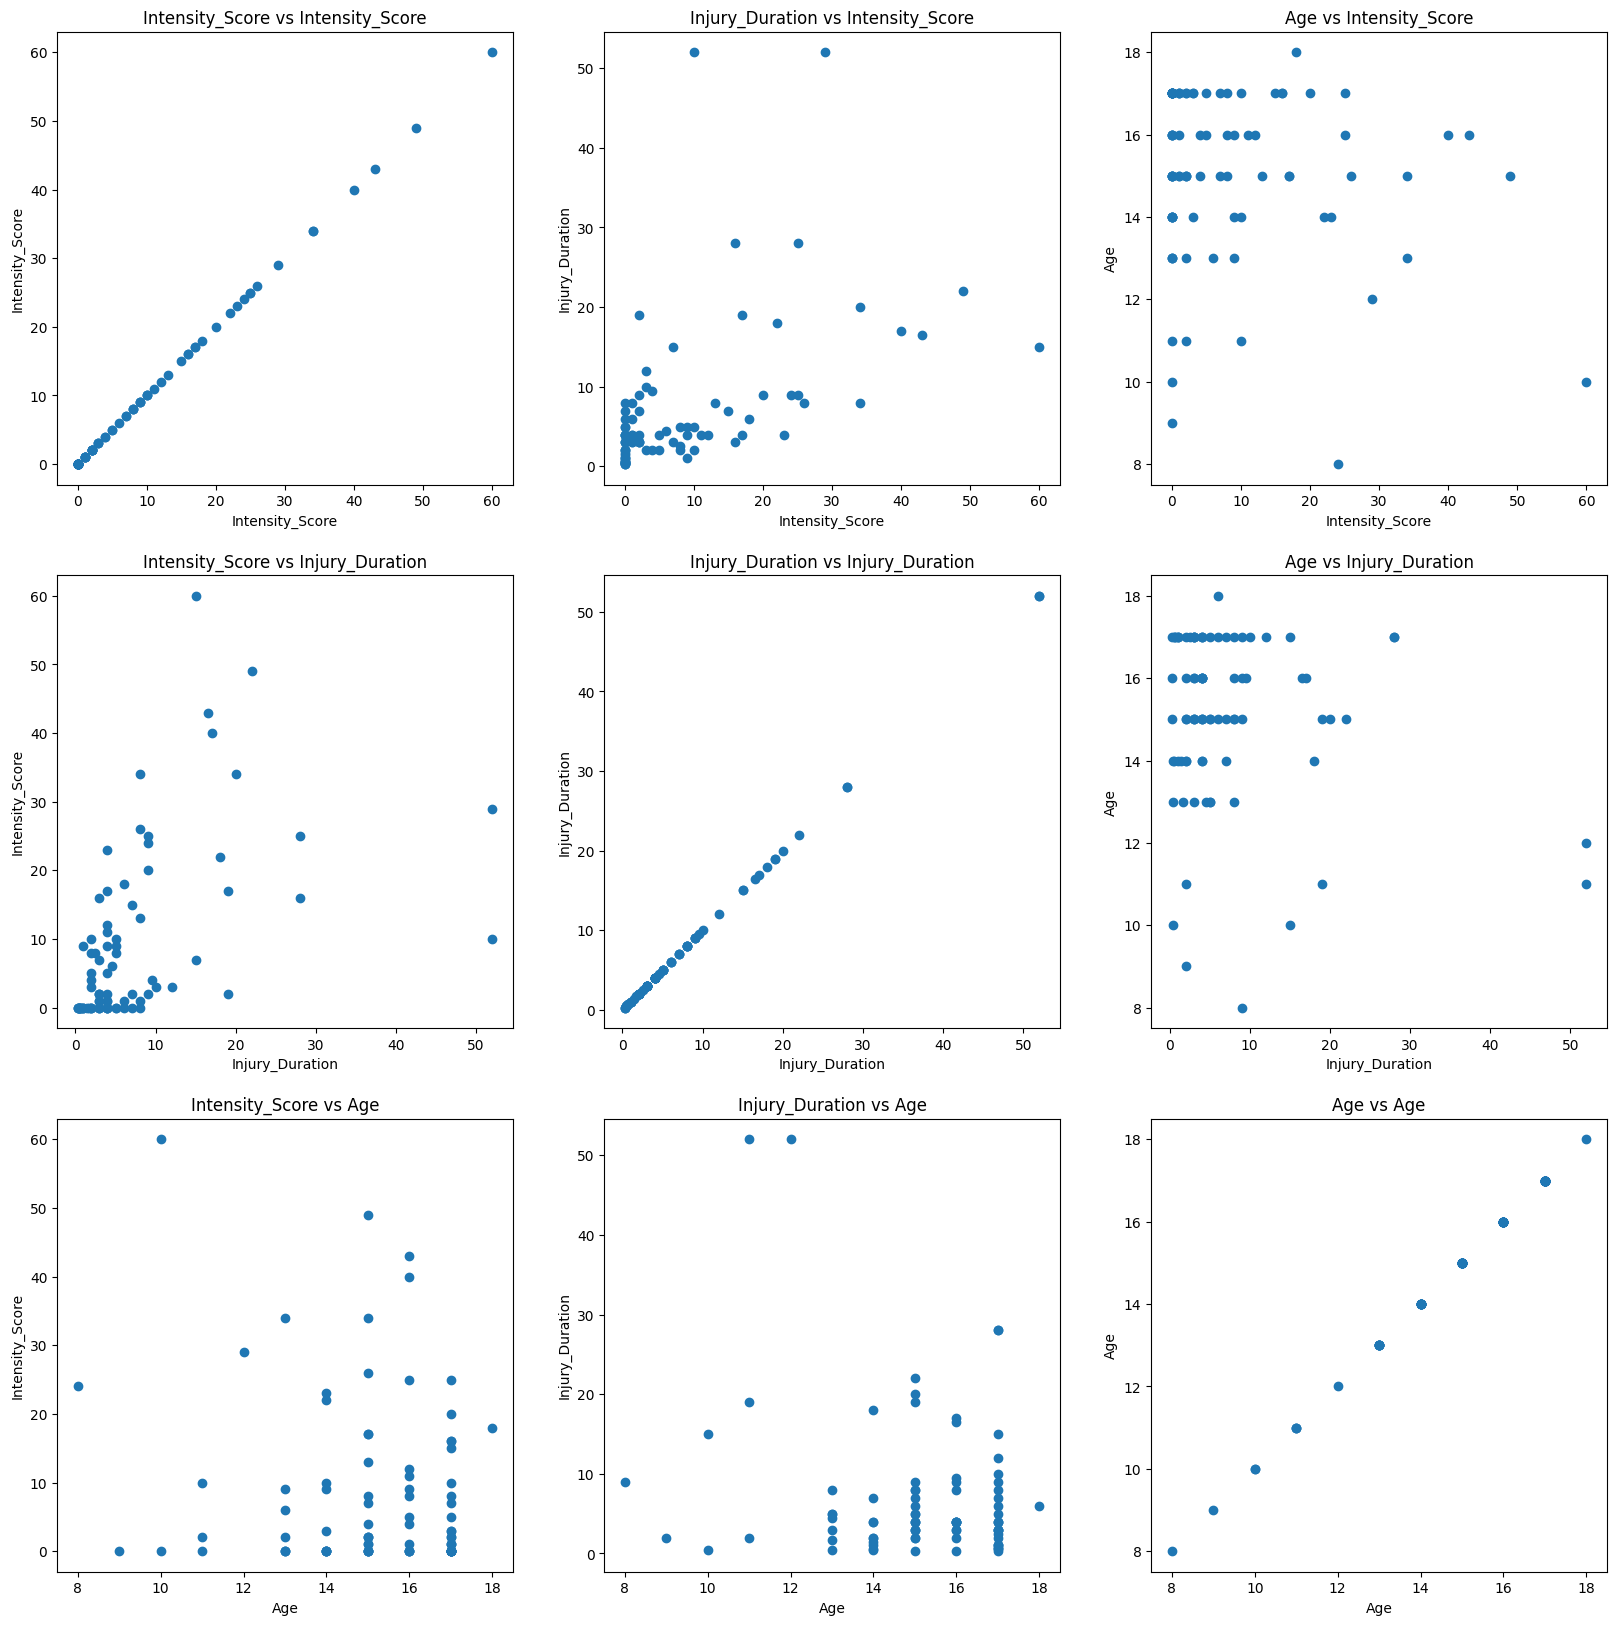

In [80]:
values = ['Intensity_Score', 'Injury_Duration', 'Age']
f, ax = plt.subplots(len(values), len(values), figsize = (20, 20))

column_names_idx = 0

for row_idx, value in enumerate(values):

    for column_idx, value2 in enumerate(values):
        ax[row_idx, column_idx].scatter(injury_data_df[value], injury_data_df[value2])

        ax[row_idx, column_idx].set_xlabel(value)
        ax[row_idx, column_idx].set_ylabel(value2);
        ax[row_idx, column_idx].set_title('{} vs {}'.format(value2, value));

# Regression Modelling

My hypothesis for this data set is that Age, injury_type, Xray, and Intensity Score will be of significance in creating a model to predict injury duration.

In [81]:
def create_model(data_df, X_columns, Y_column, formula=None):
    clean_df = data_df[X_columns + [Y_column]]

    X = clean_df[X_columns]
    Y = clean_df[Y_column]

    if formula:
        model = smf.ols(formula, data = clean_df).fit()
    else:
        model = sm.OLS(Y, sm.add_constant(X)).fit()

    return model, clean_df

def plot_model(model, data_df, X_labels, Y_label):
    X_label = X_labels[0]
    Y_predictions = model.predict()
    residuals = Y_predictions - data_df[Y_label]

    print('MSE: {}'.format(mse(data_df[Y_label], Y_predictions)))

    plot_count = 3 if len(X_labels) > 1 or X_label in categories else 4

    f, ax = plt.subplots(1, plot_count, figsize = (6*plot_count, 5))

    ax_idx = 0

    if plot_count == 4:
        ax[ax_idx].plot(data_df[X_label], Y_predictions, color='red')
        ax[ax_idx].scatter(data_df[X_label], data_df[Y_label])
        ax[ax_idx].set_xlabel(X_label)
        ax[ax_idx].set_ylabel(Y_label)
        ax[ax_idx].set_title('{} vs {}'.format(Y_label, X_label))
        ax_idx += 1

    ax[ax_idx].hist(residuals)
    ax[ax_idx].set_title('Histogram of Residuals')
    ax_idx += 1

    qqplot(residuals, line='q', ax=ax[ax_idx])
    ax[ax_idx].set_title('Q-Q Plot')
    ax_idx += 1

    ax[ax_idx].scatter(Y_predictions, residuals)
    ax[ax_idx].hlines(y=0, xmin=0, xmax=max(Y_predictions), colors='r', lw=2)
    ax[ax_idx].set_title('Residuals vs Predicted')
    ax_idx += 1

    f.show()

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.333
Date:                Sat, 30 Nov 2024   Prob (F-statistic):             0.0715
Time:                        19:35:43   Log-Likelihood:                -308.00
No. Observations:                  85   AIC:                             620.0
Df Residuals:                      83   BIC:                             624.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.5569      7.397      2.779      0.0

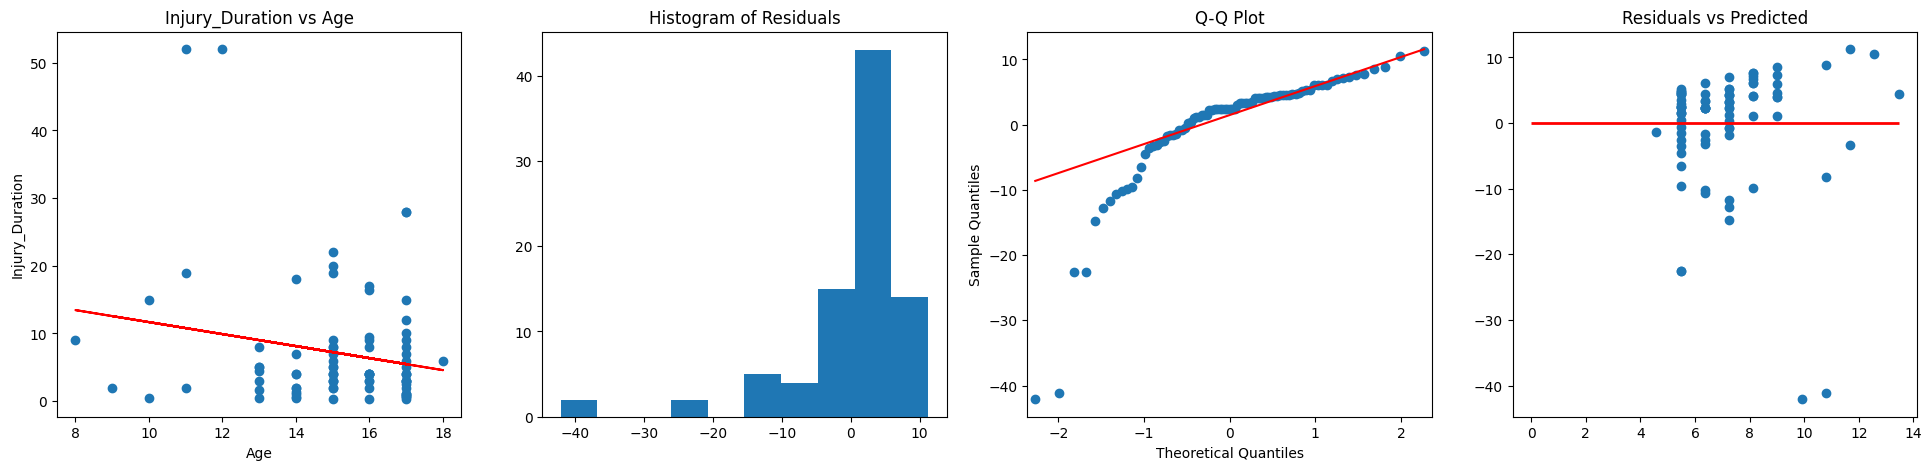

In [82]:
Y_column = 'Injury_Duration'
X_columns = ['Age']

# scaled_injury_data_df = injury_data_df.copy()
# scaled_columns = ['Age', 'Injury_Duration', 'Intensity_Score']
# scaler = MinMaxScaler()
# scaled_injury_data_df[scaled_columns] = scaler.fit_transform(injury_data_df[scaled_columns])

model, data_df = create_model(injury_data_df, X_columns, Y_column)
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     29.75
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           4.96e-07
Time:                        19:35:46   Log-Likelihood:                -296.66
No. Observations:                  85   AIC:                             597.3
Df Residuals:                      83   BIC:                             602.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.8711      1.061     

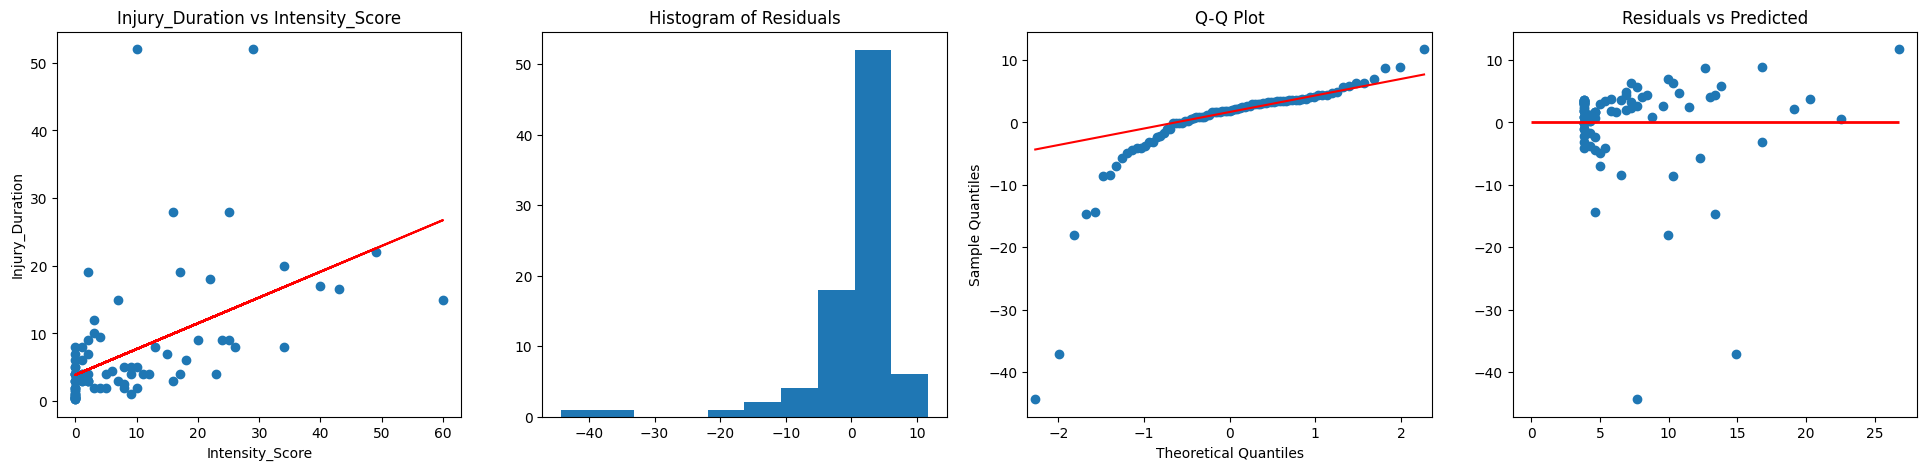

In [83]:
Y_column = 'Injury_Duration'
X_columns = ['Intensity_Score']
model, data_df = create_model(injury_data_df, X_columns, Y_column)
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.8425
Date:                Sat, 30 Nov 2024   Prob (F-statistic):              0.502
Time:                        19:35:47   Log-Likelihood:                -307.92
No. Observations:                  85   AIC:                             625.8
Df Residuals:                      80   BIC:                             638.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

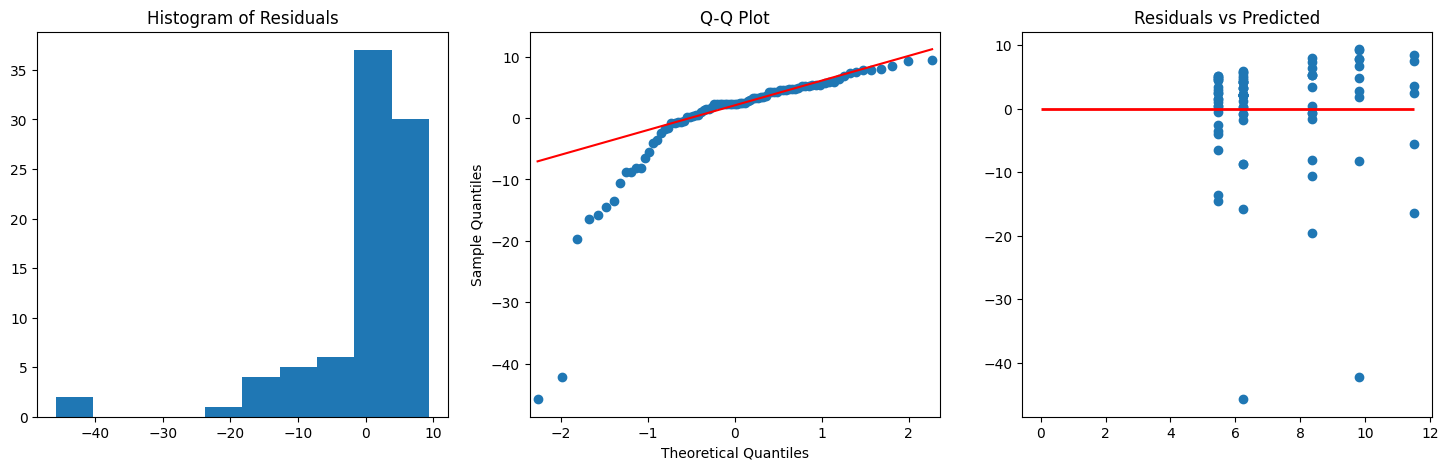

In [84]:
Y_column = 'Injury_Duration'
X_columns = ['injury_type']
model, data_df = create_model(injury_data_df, X_columns, Y_column, formula = 'Injury_Duration ~ C(injury_type)')
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.496
Date:                Sat, 30 Nov 2024   Prob (F-statistic):              0.225
Time:                        19:35:48   Log-Likelihood:                -308.92
No. Observations:                  85   AIC:                             621.8
Df Residuals:                      83   BIC:                             626.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7779      1.057     

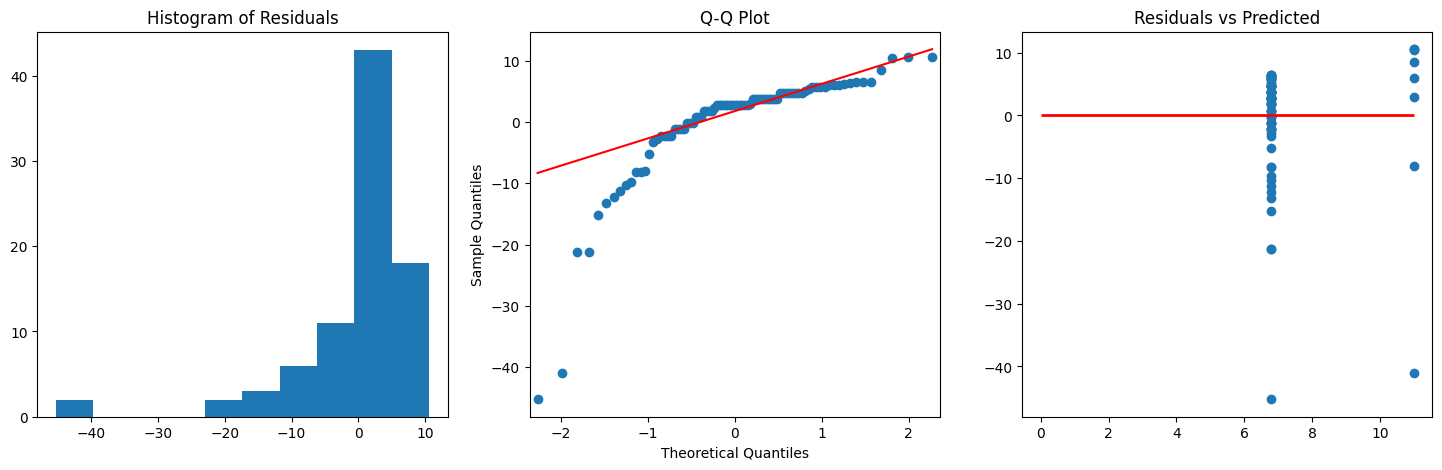

In [85]:
Y_column = 'Injury_Duration'
X_columns = ['Dazed']
model, data_df = create_model(injury_data_df, X_columns, Y_column, formula = 'Injury_Duration ~ C(Dazed)')
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7622
Date:                Sat, 30 Nov 2024   Prob (F-statistic):              0.385
Time:                        19:35:49   Log-Likelihood:                -309.29
No. Observations:                  85   AIC:                             622.6
Df Residuals:                      83   BIC:                             627.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

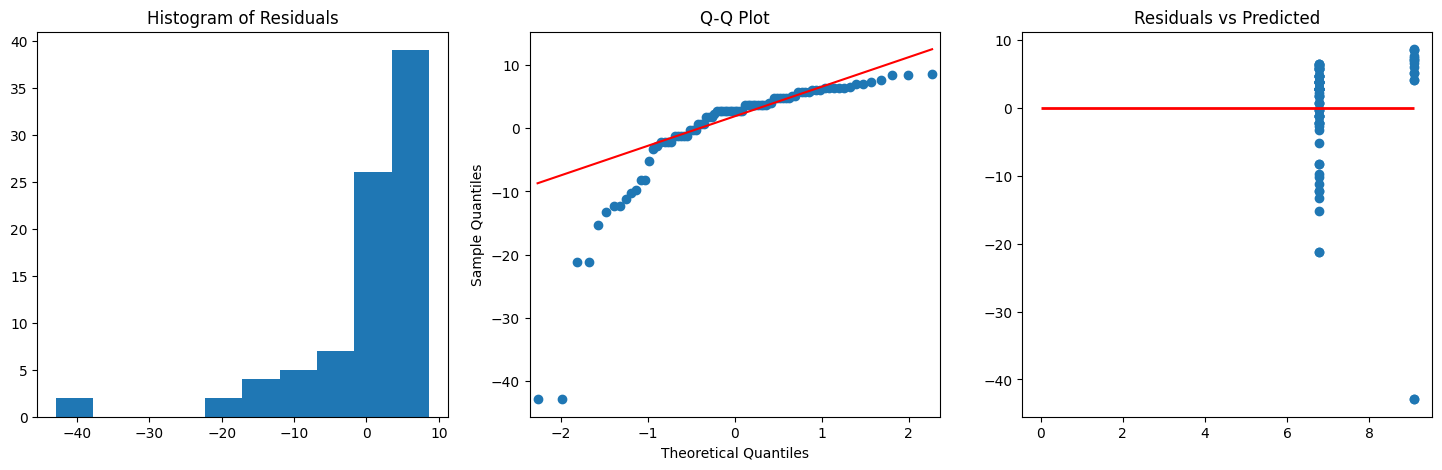

In [86]:
Y_column = 'Injury_Duration'
X_columns = ['Hospital_Admit']
model, data_df = create_model(injury_data_df, X_columns, Y_column, formula = 'Injury_Duration ~ C(Hospital_Admit)')
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                  0.005955
Date:                Sat, 30 Nov 2024   Prob (F-statistic):              0.939
Time:                        19:35:49   Log-Likelihood:                -309.67
No. Observations:                  85   AIC:                             623.3
Df Residuals:                      83   BIC:                             628.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.2400      1.323      5.

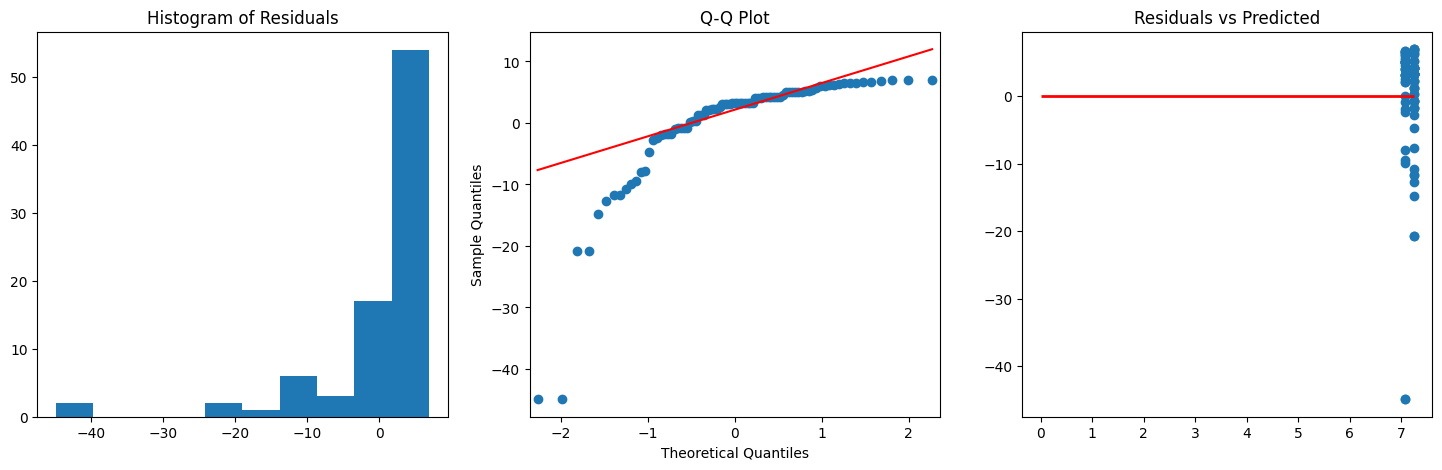

In [87]:
Y_column = 'Injury_Duration'
X_columns = ['Xray']
model, data_df = create_model(injury_data_df, X_columns, Y_column, formula = 'Injury_Duration ~ C(Xray)')
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     3.988
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           0.000342
Time:                        19:35:50   Log-Likelihood:                -293.06
No. Observations:                  85   AIC:                             606.1
Df Residuals:                      75   BIC:                             630.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

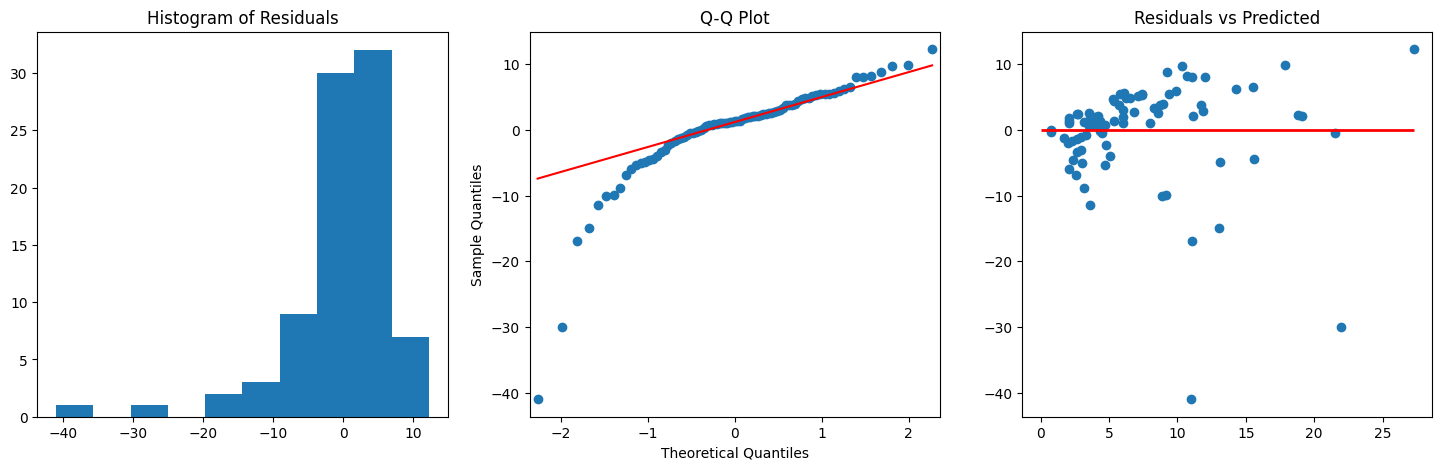

In [88]:
Y_column = 'Injury_Duration'
X_columns = ['Intensity_Score', 'Age', 'injury_type', 'Dazed', 'Hospital_Admit', 'Xray']
model, data_df = create_model(injury_data_df, X_columns, Y_column, formula = "Injury_Duration ~ Intensity_Score + Age + C(injury_type) + C(Dazed) + C(Hospital_Admit) + C(Xray)")
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     3.988
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           0.000342
Time:                        19:41:02   Log-Likelihood:                 42.324
No. Observations:                  85   AIC:                            -64.65
Df Residuals:                      75   BIC:                            -40.22
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

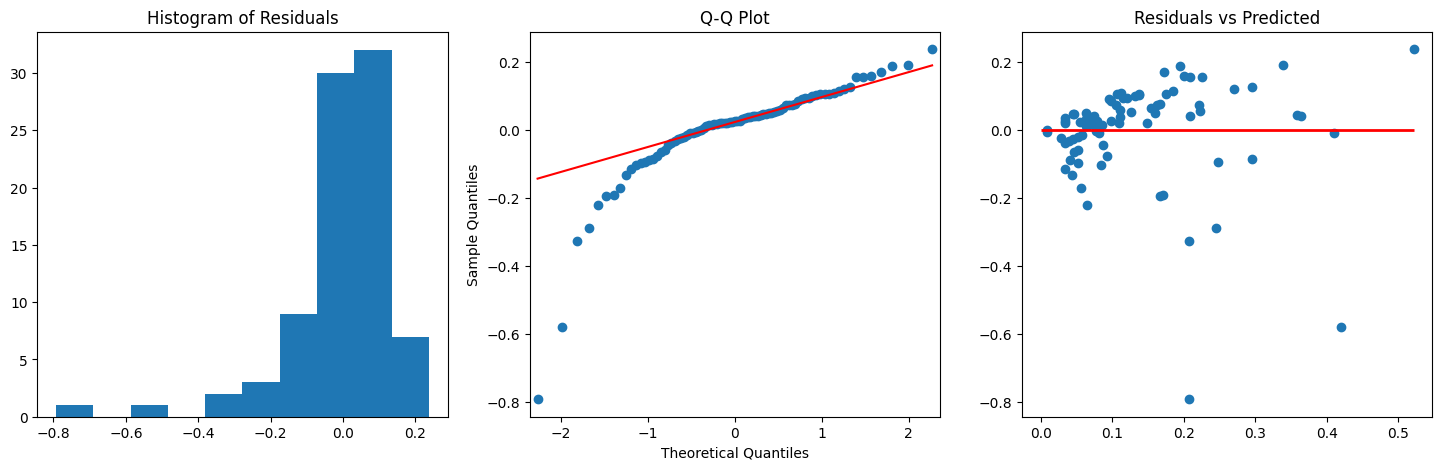

In [90]:
scaled_injury_data_df = injury_data_df.copy()
scaled_columns = ['Age', 'Injury_Duration', 'Intensity_Score']
scaler = MinMaxScaler()
scaled_injury_data_df[scaled_columns] = scaler.fit_transform(injury_data_df[scaled_columns])

Y_column = 'Injury_Duration'
X_columns = ['Intensity_Score', 'Age', 'injury_type', 'Dazed', 'Hospital_Admit', 'Xray']
model, data_df = create_model(scaled_injury_data_df, X_columns, Y_column, formula = "Injury_Duration ~ Intensity_Score + Age + C(injury_type) + C(Dazed) + C(Hospital_Admit) + C(Xray)")
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)

                            OLS Regression Results                            
Dep. Variable:        Injury_Duration   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     6.739
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           5.09e-07
Time:                        19:44:43   Log-Likelihood:                -107.91
No. Observations:                  85   AIC:                             235.8
Df Residuals:                      75   BIC:                             260.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

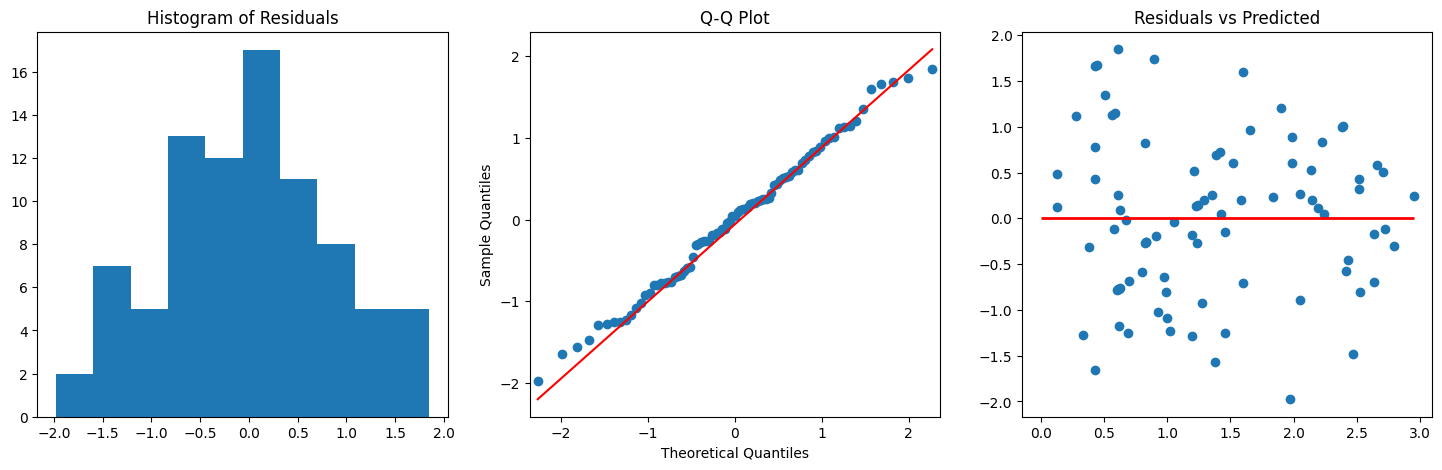

In [97]:
log_transform_injury_data_df = injury_data_df.copy()
log_transform_columns = ['Age', 'Injury_Duration', 'Intensity_Score']
log_transform_injury_data_df['Intensity_Score'] = log_transform_injury_data_df['Intensity_Score'] + 1
log_transform_injury_data_df[log_transform_columns] = np.log(log_transform_injury_data_df[log_transform_columns])

Y_column = 'Injury_Duration'
X_columns = ['Intensity_Score', 'Age', 'injury_type', 'Dazed', 'Hospital_Admit', 'Xray']
model, data_df = create_model(log_transform_injury_data_df, X_columns, Y_column, formula = "Injury_Duration ~ Intensity_Score + Age + C(injury_type) + C(Dazed) + C(Hospital_Admit) + C(Xray)")
print(model.summary())
plot_model(model, data_df, X_columns, Y_column)